In [5]:
import os
import numpy as np
import pandas as pd
import random
import datetime
import time

from pandas import ExcelWriter
from torchsummary import summary
import torch
import math
import warnings
warnings.filterwarnings("ignore")

from torch import nn
from torch import Tensor
from einops.layers.torch import Rearrange, Reduce
from einops import rearrange, reduce, repeat
import torch.nn.functional as F

from utils import calMetrics
from utils import calculatePerClass
from utils import numberClassChannel
from utils import load_data_evaluate

from torch.autograd import Variable

# Set device to CPU
device = torch.device("cpu")

class PatchEmbeddingCNN(nn.Module):
    def __init__(self, f1=16, kernel_size=64, D=2, pooling_size1=8, pooling_size2=8, dropout_rate=0.3, number_channel=22, emb_size=40):
        super().__init__()
        f2 = D*f1
        self.cnn_module = nn.Sequential(
            nn.Conv2d(1, f1, (1, kernel_size), (1, 1), padding='same', bias=False),
            nn.BatchNorm2d(f1),
            nn.Conv2d(f1, f2, (number_channel, 1), (1, 1), groups=f1, padding='valid', bias=False),
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pooling_size1)),
            nn.Dropout(dropout_rate),
            nn.Conv2d(f2, f2, (1, 16), padding='same', bias=False),
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pooling_size2)),
            nn.Dropout(dropout_rate),  
        )
        self.projection = nn.Sequential(
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.cnn_module(x)
        x = self.projection(x)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class ClassificationHead(nn.Sequential):
    def __init__(self, flatten_number, n_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(flatten_number, n_classes)
        )
    def forward(self, x):
        out = self.fc(x)
        return out

class ResidualAdd(nn.Module):
    def __init__(self, fn, emb_size, drop_p):
        super().__init__()
        self.fn = fn
        self.drop = nn.Dropout(drop_p)
        self.layernorm = nn.LayerNorm(emb_size)
    def forward(self, x, **kwargs):
        x_input = x
        res = self.fn(x, **kwargs)
        out = self.layernorm(self.drop(res)+x_input)
        return out

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=4,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                MultiHeadAttention(emb_size, num_heads, drop_p),
                ), emb_size, drop_p),
            ResidualAdd(nn.Sequential(
                FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                ), emb_size, drop_p)
            )    

class TransformerEncoder(nn.Sequential):
    def __init__(self, heads, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size, heads) for _ in range(depth)])

class BranchEEGNetTransformer(nn.Sequential):
    def __init__(self, heads=4, 
                 depth=6, 
                 emb_size=40, 
                 number_channel=22,
                 f1 = 20,
                 kernel_size = 64,
                 D = 2,
                 pooling_size1 = 8,
                 pooling_size2 = 8,
                 dropout_rate = 0.3,
                 **kwargs):
        super().__init__(
            PatchEmbeddingCNN(f1=f1, 
                                 kernel_size=kernel_size,
                                 D=D, 
                                 pooling_size1=pooling_size1, 
                                 pooling_size2=pooling_size2, 
                                 dropout_rate=dropout_rate,
                                 number_channel=number_channel,
                                 emb_size=emb_size),
        )

class PositioinalEncoding(nn.Module):
    def __init__(self, embedding, length=100, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.encoding = nn.Parameter(torch.randn(1, length, embedding))
    def forward(self, x):
        x = x + self.encoding[:, :x.shape[1], :].to(x.device)
        return self.dropout(x)        

class EEGTransformer(nn.Module):
    def __init__(self, heads=4, 
                 emb_size=40,
                 depth=6, 
                 database_type='A', 
                 eeg1_f1 = 20,
                 eeg1_kernel_size = 64,
                 eeg1_D = 2,
                 eeg1_pooling_size1 = 8,
                 eeg1_pooling_size2 = 8,
                 eeg1_dropout_rate = 0.3,
                 eeg1_number_channel = 22,
                 flatten_eeg1 = 600,
                 **kwargs):
        super().__init__()
        self.number_class, self.number_channel = numberClassChannel(database_type)
        self.emb_size = emb_size
        self.flatten_eeg1 = flatten_eeg1
        self.flatten = nn.Flatten()
        self.cnn = BranchEEGNetTransformer(heads, depth, emb_size, number_channel=self.number_channel,
                                              f1 = eeg1_f1,
                                              kernel_size = eeg1_kernel_size,
                                              D = eeg1_D,
                                              pooling_size1 = eeg1_pooling_size1,
                                              pooling_size2 = eeg1_pooling_size2,
                                              dropout_rate = eeg1_dropout_rate,
                                              )
        self.position = PositioinalEncoding(emb_size, dropout=0.1)
        self.trans = TransformerEncoder(heads, depth, emb_size)
        self.flatten = nn.Flatten()
        self.classification = ClassificationHead(self.flatten_eeg1 , self.number_class)
    def forward(self, x):
        cnn = self.cnn(x)
        cnn = cnn * math.sqrt(self.emb_size)
        cnn = self.position(cnn)
        trans = self.trans(cnn)
        features = cnn+trans
        out = self.classification(self.flatten(features))
        return features, out

class ExP():
    def __init__(self, nsub, data_dir, result_name, 
                 epochs=2000, 
                 number_aug=2,
                 number_seg=8, 
                 gpus=[0], 
                 evaluate_mode = 'subject-dependent',
                 heads=4, 
                 emb_size=40,
                 depth=6, 
                 dataset_type='A',
                 eeg1_f1 = 20,
                 eeg1_kernel_size = 64,
                 eeg1_D = 2,
                 eeg1_pooling_size1 = 8,
                 eeg1_pooling_size2 = 8,
                 eeg1_dropout_rate = 0.3,
                 flatten_eeg1 = 600, 
                 validate_ratio = 0.2,
                 learning_rate = 0.001,
                 batch_size = 72,  
                 ):
        super(ExP, self).__init__()
        self.dataset_type = dataset_type
        self.batch_size = batch_size
        self.lr = learning_rate
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_epochs = epochs
        self.nSub = nsub
        self.number_augmentation = number_aug
        self.number_seg = number_seg
        self.root = data_dir
        self.heads=heads
        self.emb_size=emb_size
        self.depth=depth
        self.result_name = result_name
        self.evaluate_mode = evaluate_mode
        self.validate_ratio = validate_ratio

        self.criterion_cls = torch.nn.CrossEntropyLoss().to(device)

        self.number_class, self.number_channel = numberClassChannel(self.dataset_type)
        self.model = EEGTransformer(
             heads=self.heads, 
             emb_size=self.emb_size,
             depth=self.depth, 
            database_type=self.dataset_type, 
            eeg1_f1=eeg1_f1, 
            eeg1_D=eeg1_D,
            eeg1_kernel_size=eeg1_kernel_size,
            eeg1_pooling_size1 = eeg1_pooling_size1,
            eeg1_pooling_size2 = eeg1_pooling_size2,
            eeg1_dropout_rate = eeg1_dropout_rate,
            eeg1_number_channel = self.number_channel,
            flatten_eeg1 = flatten_eeg1,  
            ).to(device)
        self.model_filename = self.result_name + '/model_{}.pth'.format(self.nSub)

    def interaug(self, timg, label):  
        aug_data = []
        aug_label = []
        number_records_by_augmentation = self.number_augmentation * int(self.batch_size / self.number_class)
        number_segmentation_points = 1000 // self.number_seg
        for clsAug in range(self.number_class):
            cls_idx = np.where(label == clsAug + 1)
            tmp_data = timg[cls_idx]
            tmp_label = label[cls_idx]
            tmp_aug_data = np.zeros((number_records_by_augmentation, 1, self.number_channel, 1000))
            for ri in range(number_records_by_augmentation):
                for rj in range(self.number_seg):
                    rand_idx = np.random.randint(0, tmp_data.shape[0], self.number_seg)
                    tmp_aug_data[ri, :, :, rj * number_segmentation_points:(rj + 1) * number_segmentation_points] = \
                        tmp_data[rand_idx[rj], :, :, rj * number_segmentation_points:(rj + 1) * number_segmentation_points]
            aug_data.append(tmp_aug_data)
            aug_label.append(tmp_label[:number_records_by_augmentation])
        aug_data = np.concatenate(aug_data)
        aug_label = np.concatenate(aug_label)
        aug_shuffle = np.random.permutation(len(aug_data))
        aug_data = aug_data[aug_shuffle, :, :]
        aug_label = aug_label[aug_shuffle]
        aug_data = torch.from_numpy(aug_data).to(device).float()
        aug_label = torch.from_numpy(aug_label-1).to(device).long()
        return aug_data, aug_label

    def get_source_data(self):
        (self.train_data,
         self.train_label, 
         self.test_data, 
         self.test_label) = load_data_evaluate(self.root, self.dataset_type, self.nSub, mode_evaluate=self.evaluate_mode)
        self.train_data = np.expand_dims(self.train_data, axis=1)
        self.train_label = np.transpose(self.train_label)
        self.allData = self.train_data
        self.allLabel = self.train_label[0]
        shuffle_num = np.random.permutation(len(self.allData))
        self.allData = self.allData[shuffle_num, :, :, :]
        self.allLabel = self.allLabel[shuffle_num]
        print('-'*20, "train size：", self.train_data.shape, "test size：", self.test_data.shape)
        self.test_data = np.expand_dims(self.test_data, axis=1)
        self.test_label = np.transpose(self.test_label)
        self.testData = self.test_data
        self.testLabel = self.test_label[0]
        target_mean = np.mean(self.allData)
        target_std = np.std(self.allData)
        self.allData = (self.allData - target_mean) / target_std
        self.testData = (self.testData - target_mean) / target_std
        isSaveDataLabel = False
        if isSaveDataLabel:
            np.save("./gradm_data/train_data_{}.npy".format(self.nSub), self.allData)
            np.save("./gradm_data/train_lable_{}.npy".format(self.nSub), self.allLabel)
            np.save("./gradm_data/test_data_{}.npy".format(self.nSub), self.testData)
            np.save("./gradm_data/test_label_{}.npy".format(self.nSub), self.testLabel)
        return self.allData, self.allLabel, self.testData, self.testLabel

    def train(self):
        img, label, test_data, test_label = self.get_source_data()
        img = torch.from_numpy(img)
        label = torch.from_numpy(label - 1)
        dataset = torch.utils.data.TensorDataset(img, label)
        test_data = torch.from_numpy(test_data)
        test_label = torch.from_numpy(test_label - 1)
        test_dataset = torch.utils.data.TensorDataset(test_data, test_label)
        self.test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=self.batch_size, shuffle=False)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        test_data = test_data.to(device).float()
        test_label = test_label.to(device).long()
        best_epoch = 0
        num = 0
        min_loss = 100
        result_process = []
        for e in range(self.n_epochs):
            self.dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)
            epoch_process = {}
            epoch_process['epoch'] = e
            self.model.train()
            outputs_list = []
            label_list = []
            val_data_list = []
            val_label_list = []
            for i, (img, label) in enumerate(self.dataloader):
                number_sample = img.shape[0]
                number_validate = int(self.validate_ratio * number_sample)
                train_data = img[:-number_validate]
                train_label = label[:-number_validate]
                val_data_list.append(img[number_validate:])
                val_label_list.append(label[number_validate:])
                img = train_data.to(device).float()
                label = train_label.to(device).long()
                aug_data, aug_label = self.interaug(self.allData, self.allLabel)
                img = torch.cat((img, aug_data))
                label = torch.cat((label, aug_label))
                features, outputs = self.model(img)
                outputs_list.append(outputs)
                label_list.append(label)
                loss = self.criterion_cls(outputs, label) 
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            del img
            torch.cuda.empty_cache()
            if (e + 1) % 1 == 0:
                self.model.eval()
                val_data = torch.cat(val_data_list).to(device).float()
                val_label = torch.cat(val_label_list).to(device).long()
                val_dataset = torch.utils.data.TensorDataset(val_data, val_label)
                self.val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=self.batch_size, shuffle=False)
                outputs_list = []
                with torch.no_grad():
                    for i, (img, _) in enumerate(self.val_dataloader):
                        img = img.to(device).float()
                        _, Cls = self.model(img)
                        outputs_list.append(Cls)
                        del img, Cls
                        torch.cuda.empty_cache()
                Cls = torch.cat(outputs_list)
                val_loss = self.criterion_cls(Cls, val_label)
                val_pred = torch.max(Cls, 1)[1]
                val_acc = float((val_pred == val_label).cpu().numpy().astype(int).sum()) / float(val_label.size(0))
                epoch_process['val_acc'] = val_acc                
                epoch_process['val_loss'] = val_loss.detach().cpu().numpy()  
                train_pred = torch.max(outputs, 1)[1]
                train_acc = float((train_pred == label).cpu().numpy().astype(int).sum()) / float(label.size(0))
                epoch_process['train_acc'] = train_acc
                epoch_process['train_loss'] = loss.detach().cpu().numpy()
                num = num + 1
                if min_loss>val_loss:
                    min_loss = val_loss
                    best_epoch = e
                    epoch_process['epoch'] = e
                    torch.save(self.model, self.model_filename)
                    print("{}_{} train_acc: {:.4f} train_loss: {:.6f}\tval_acc: {:.6f} val_loss: {:.7f}".format(self.nSub,
                                                                                           epoch_process['epoch'],
                                                                                           epoch_process['train_acc'],
                                                                                           epoch_process['train_loss'],
                                                                                           epoch_process['val_acc'],
                                                                                           epoch_process['val_loss'],
                                                                                        ))
            result_process.append(epoch_process)  
            del label, val_data, val_label
            torch.cuda.empty_cache()
        self.model.eval()
        self.model = torch.load(self.model_filename, map_location=device)
        outputs_list = []
        with torch.no_grad():
            for i, (img, label) in enumerate(self.test_dataloader):
                img_test = img.to(device).float()
                features, outputs = self.model(img_test)
                val_pred = torch.max(outputs, 1)[1]
                outputs_list.append(outputs)
        outputs = torch.cat(outputs_list) 
        y_pred = torch.max(outputs, 1)[1]
        test_acc = float((y_pred == test_label).cpu().numpy().astype(int).sum()) / float(test_label.size(0))
        print("epoch: ", best_epoch, '\tThe test accuracy is:', test_acc)
        df_process = pd.DataFrame(result_process)
        return test_acc, test_label, y_pred, df_process, best_epoch

def main(dirs,                
         evaluate_mode = 'subject-dependent',
         heads=8,
         emb_size=48,
         depth=3,
         dataset_type='A',
         eeg1_f1=20,
         eeg1_kernel_size=64,
         eeg1_D=2,
         eeg1_pooling_size1=8,
         eeg1_pooling_size2=8,
         eeg1_dropout_rate=0.3,
         flatten_eeg1=600,   
         validate_ratio = 0.2
         ):
    if not os.path.exists(dirs):
        os.makedirs(dirs)
    result_write_metric = ExcelWriter(dirs+"/result_metric.xlsx")
    result_metric_dict = {}
    y_true_pred_dict = { }
    process_write = ExcelWriter(dirs+"/process_train.xlsx")
    pred_true_write = ExcelWriter(dirs+"/pred_true.xlsx")
    subjects_result = []
    best_epochs = []
    for i in range(N_SUBJECT):      
        starttime = datetime.datetime.now()
        seed_n = np.random.randint(2024)
        print('seed is ' + str(seed_n))
        random.seed(seed_n)
        np.random.seed(seed_n)
        torch.manual_seed(seed_n)
        index_round =0
        print('Subject %d' % (i+1))
        exp = ExP(i + 1, DATA_DIR, dirs, EPOCHS, N_AUG, N_SEG, None, 
                  evaluate_mode = evaluate_mode,
                  heads=heads, 
                  emb_size=emb_size,
                  depth=depth, 
                  dataset_type=dataset_type,
                  eeg1_f1 = eeg1_f1,
                  eeg1_kernel_size = eeg1_kernel_size,
                  eeg1_D = eeg1_D,
                  eeg1_pooling_size1 = eeg1_pooling_size1,
                  eeg1_pooling_size2 = eeg1_pooling_size2,
                  eeg1_dropout_rate = eeg1_dropout_rate,
                  flatten_eeg1 = flatten_eeg1,  
                  validate_ratio = validate_ratio
                  )
        testAcc, Y_true, Y_pred, df_process, best_epoch = exp.train()
        true_cpu = Y_true.cpu().numpy().astype(int)
        pred_cpu = Y_pred.cpu().numpy().astype(int)
        df_pred_true = pd.DataFrame({'pred': pred_cpu, 'true': true_cpu})
        df_pred_true.to_excel(pred_true_write, sheet_name=str(i+1))
        y_true_pred_dict[i] = df_pred_true
        accuracy, precison, recall, f1, kappa = calMetrics(true_cpu, pred_cpu)
        subject_result = {'accuray': accuracy*100,
                          'precision': precison*100,
                          'recall': recall*100,
                          'f1': f1*100, 
                          'kappa': kappa*100
                          }
        subjects_result.append(subject_result)
        df_process.to_excel(process_write, sheet_name=str(i+1))
        best_epochs.append(best_epoch)
        print(' THE BEST ACCURACY IS ' + str(testAcc) + "\tkappa is " + str(kappa) )
        endtime = datetime.datetime.now()
        print('subject %d duration: '%(i+1) + str(endtime - starttime))
        if i == 0:
            yt = Y_true
            yp = Y_pred
        else:
            yt = torch.cat((yt, Y_true))
            yp = torch.cat((yp, Y_pred))
        df_result = pd.DataFrame(subjects_result)
    process_write.close()
    pred_true_write.close()
    print('**The average Best accuracy is: ' + str(df_result['accuray'].mean()) + "kappa is: " + str(df_result['kappa'].mean()) + "\n" )
    print("best epochs: ", best_epochs)
    result_metric_dict = df_result
    mean = df_result.mean(axis=0)
    mean.name = 'mean'
    std = df_result.std(axis=0)
    std.name = 'std'
    df_result = pd.concat([df_result, pd.DataFrame(mean).T, pd.DataFrame(std).T])
    df_result.to_excel(result_write_metric, index=False)
    print('-'*9, ' all result ', '-'*9)
    print(df_result)
    print("*"*40)
    result_write_metric.close()
    return result_metric_dict

if __name__ == "__main__":
    DATA_DIR = r'./mymat_raw/'
    EVALUATE_MODE = 'LOSO-No'
    N_SUBJECT = 9
    N_AUG = 3
    N_SEG = 8
    EPOCHS = 1000
    EMB_DIM = 16
    HEADS = 2
    DEPTH = 6
    TYPE = 'B'
    validate_ratio = 0.3
    EEGNet1_F1 = 8
    EEGNet1_KERNEL_SIZE=64
    EEGNet1_D=2
    EEGNet1_POOL_SIZE1 = 8
    EEGNet1_POOL_SIZE2 = 8
    FLATTEN_EEGNet1 = 240
    if EVALUATE_MODE!='LOSO':
        EEGNet1_DROPOUT_RATE = 0.5
    else:
        EEGNet1_DROPOUT_RATE = 0.25    
    parameters_list = ['A']
    for TYPE in parameters_list:
        number_class, number_channel = numberClassChannel(TYPE)
        RESULT_NAME = "CTNet_{}_heads_{}_depth_{}_{}".format(TYPE, HEADS, DEPTH, int(time.time()))
        sModel = EEGTransformer(
            heads=HEADS, 
            emb_size=EMB_DIM,
            depth=DEPTH, 
            database_type=TYPE,
            eeg1_f1=EEGNet1_F1, 
            eeg1_D=EEGNet1_D,
            eeg1_kernel_size=EEGNet1_KERNEL_SIZE,
            eeg1_pooling_size1 = EEGNet1_POOL_SIZE1,
            eeg1_pooling_size2 = EEGNet1_POOL_SIZE2,
            eeg1_dropout_rate = EEGNet1_DROPOUT_RATE,
            eeg1_number_channel = number_channel,
            flatten_eeg1 = FLATTEN_EEGNet1,  
            ).to(device)
        summary(sModel, (1, number_channel, 1000)) 
        print(time.asctime(time.localtime(time.time())))
        result = main(RESULT_NAME,
                        evaluate_mode = EVALUATE_MODE,
                        heads=HEADS, 
                        emb_size=EMB_DIM,
                        depth=DEPTH, 
                        dataset_type=TYPE,
                        eeg1_f1 = EEGNet1_F1,
                        eeg1_kernel_size = EEGNet1_KERNEL_SIZE,
                        eeg1_D = EEGNet1_D,
                        eeg1_pooling_size1 = EEGNet1_POOL_SIZE1,
                        eeg1_pooling_size2 = EEGNet1_POOL_SIZE2,
                        eeg1_dropout_rate = EEGNet1_DROPOUT_RATE,
                        flatten_eeg1 = FLATTEN_EEGNet1,
                        validate_ratio = validate_ratio,
                      )
        print(time.asctime(time.localtime(time.time())))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 22, 1000]             512
       BatchNorm2d-2          [-1, 8, 22, 1000]              16
            Conv2d-3          [-1, 16, 1, 1000]             352
       BatchNorm2d-4          [-1, 16, 1, 1000]              32
               ELU-5          [-1, 16, 1, 1000]               0
         AvgPool2d-6           [-1, 16, 1, 125]               0
           Dropout-7           [-1, 16, 1, 125]               0
            Conv2d-8           [-1, 16, 1, 125]           4,096
       BatchNorm2d-9           [-1, 16, 1, 125]              32
              ELU-10           [-1, 16, 1, 125]               0
        AvgPool2d-11            [-1, 16, 1, 15]               0
          Dropout-12            [-1, 16, 1, 15]               0
        Rearrange-13               [-1, 15, 16]               0
PatchEmbeddingCNN-14               [-1,

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from interbotix_common_modules.common_robot.robot import robot_startup, robot_shutdown
from interbotix_xs_modules.xs_robot.arm import InterbotixManipulatorXS

# === Parameters ===
subject_id = 1
num_trials = 10
step = 0.03  # 3 cm per trial

# === Load predictions ===
df = pd.read_excel("pred_true.xlsx", sheet_name=str(subject_id))
df = df.iloc[:num_trials]

# === Initialize position and logs for plotting ===
x, z = 0.0, 0.0
x_gt, z_gt = 0.0, 0.0

x_log, z_log = [], []
x_gt_log, z_gt_log = [], []

# === Initialize robot ===
bot = InterbotixManipulatorXS(
    robot_model='px150',
    group_name='arm',
    gripper_name='gripper',
)
robot_startup()
bot.arm.go_to_home_pose()

# === Trial loop ===
for i, (pred, true) in enumerate(zip(df["pred"], df["true"])):
    dx, dz = 0.0, 0.0
    dx_gt, dz_gt = 0.0, 0.0

    # Predicted delta
    if pred == 0:   dx = -step   # forward
    elif pred == 1: dx = step    # backward
    elif pred == 2: dz = step    # up
    elif pred == 3: dz = -step   # down

    # Ground truth delta
    if true == 0:   dx_gt = -step
    elif true == 1: dx_gt = step
    elif true == 2: dz_gt = step
    elif true == 3: dz_gt = -step

    # Update for plotting
    x += dx
    z += dz
    x_gt += dx_gt
    z_gt += dz_gt
    x_log.append(x)
    z_log.append(z)
    x_gt_log.append(x_gt)
    z_gt_log.append(z_gt)

    # === Send movement delta command ===
    print(f"[Trial {i+1}] Class={pred} | Δx={dx:.2f}, Δz={dz:.2f}")
    bot.arm.set_ee_cartesian_trajectory(x=dx, z=dz)
    time.sleep(1)

# === Shutdown ===
bot.arm.go_to_sleep_pose()
robot_shutdown()
print("Execution complete.")

# === Plot comparison ===
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x_log, label='Predicted X')
plt.plot(x_gt_log, label='True X', linestyle='dashed')
plt.title("X Movement (Left/Right)")
plt.xlabel("Trial")
plt.ylabel("Accumulated Position (m)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(z_log, label='Predicted Z')
plt.plot(z_gt_log, label='True Z', linestyle='dashed')
plt.title("Z Movement (Up/Down)")
plt.xlabel("Trial")
plt.ylabel("Accumulated Position (m)")
plt.legend()

plt.tight_layout()
plt.savefig("comparison_plot_fixed.png")
plt.show()


/home/mscrobotics2425laptop18/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
[INFO] [1754487816.346459408] [interbotix_robot_manipulation]: Initialized InterbotixRobotNode!
[INFO] [1754487816.386321176] [interbotix_robot_manipulation]: 
	Robot Name: px150
	Robot Model: px150
[INFO] [1754487816.386792736] [interbotix_robot_manipulation]: Initialized InterbotixRobotXSCore!
[INFO] [1754487816.420112902] [interbotix_robot_manipulation]: 
	Arm Group Name: arm
	Moving Time: 2.00 seconds
	Acceleration Time: 0.30 seconds
	Drive Mode: Time-Based-Profile
[INFO] [1754487816.420469006] [interbotix_robot_manipulation]: Initialized InterbotixArmXSInterface!
[INFO] [1754487816.946512570] [in

[Trial 1] Class=0 | Δx=-0.03, Δz=0.00
[Trial 2] Class=1 | Δx=0.03, Δz=0.00
[Trial 3] Class=1 | Δx=0.03, Δz=0.00
[Trial 4] Class=0 | Δx=-0.03, Δz=0.00
[Trial 5] Class=0 | Δx=-0.03, Δz=0.00
[Trial 6] Class=0 | Δx=-0.03, Δz=0.00
[Trial 7] Class=1 | Δx=0.03, Δz=0.00
[Trial 8] Class=3 | Δx=0.00, Δz=-0.03
[Trial 9] Class=1 | Δx=0.03, Δz=0.00


KeyboardInterrupt: 

### For PX150 Manipulator

## Degree of Freedom (DoF) is 5
## Joint order: [waist, shoulder, elbow, wrist_angle, wrist_rotate, gripper]
## Arm groups: [waist, shoulder, elbow, wrist_angle, wrist_rotate]

## Sleep position: [0, -1.80, 1.55, 0.8, 0, 0]
# bot.arm.set_single_joint_position(joint_name='waist', position=np.pi/2.0)

/home/mscrobotics2425laptop18/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
[INFO] [1754572418.115095441] [interbotix_robot_manipulation]: Initialized InterbotixRobotNode!
[INFO] [1754572418.159166286] [interbotix_robot_manipulation]: 
	Robot Name: px150
	Robot Model: px150
[INFO] [1754572418.159500689] [interbotix_robot_manipulation]: Initialized InterbotixRobotXSCore!
[INFO] [1754572418.183958080] [interbotix_robot_manipulation]: 
	Arm Group Name: arm
	Moving Time: 2.00 seconds
	Acceleration Time: 0.30 seconds
	Drive Mode: Time-Based-Profile
[INFO] [1754572418.184235522] [interbotix_robot_manipulation]: Initialized InterbotixArmXSInterface!
[INFO] [1754572418.707628408] [in

[Trial 1] Class=0 | Δy=-0.03, Δz=0.00 | y=-0.03, z=0.00
[Trial 2] Class=1 | Δy=0.03, Δz=0.00 | y=0.00, z=0.00
[Trial 3] Class=1 | Δy=0.03, Δz=0.00 | y=0.03, z=0.00
[Trial 4] Class=0 | Δy=-0.03, Δz=0.00 | y=0.00, z=0.00
[Trial 5] Class=0 | Δy=-0.03, Δz=0.00 | y=-0.03, z=0.00
[Trial 6] Class=0 | Δy=-0.03, Δz=0.00 | y=-0.06, z=0.00
[Trial 7] Class=1 | Δy=0.03, Δz=0.00 | y=-0.03, z=0.00
[Trial 8] Class=3 | Δy=0.00, Δz=-0.03 | y=-0.03, z=-0.03
[Trial 9] Class=1 | Δy=0.03, Δz=0.00 | y=0.00, z=-0.03
[Trial 10] Class=3 | Δy=0.00, Δz=-0.03 | y=0.00, z=-0.06
Execution complete.


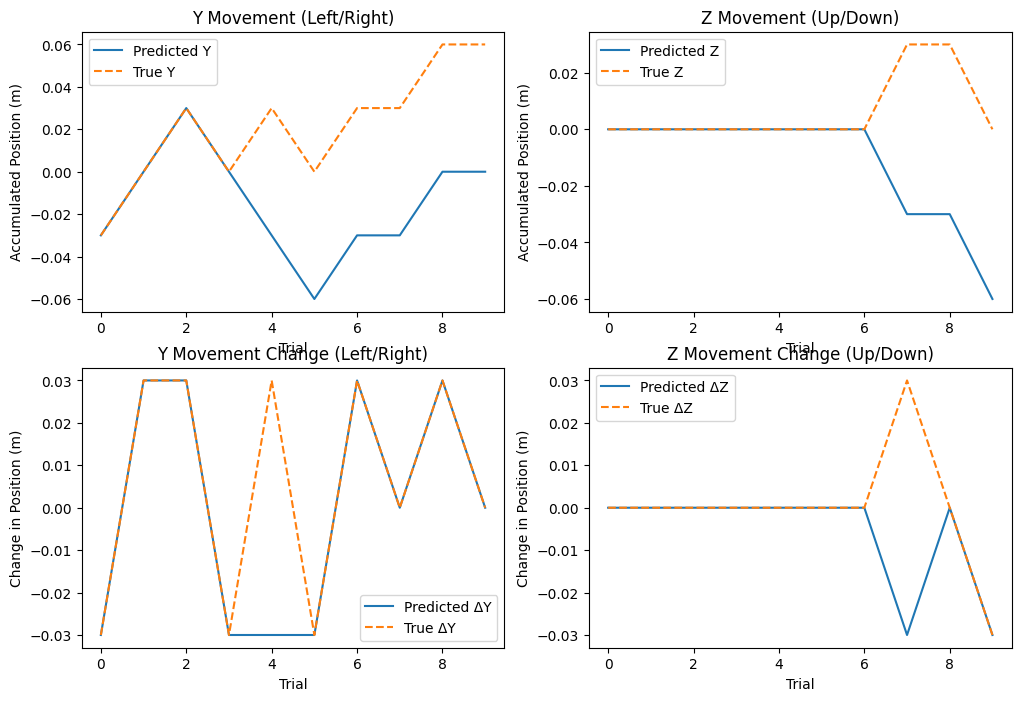

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from interbotix_common_modules.common_robot.robot import robot_startup, robot_shutdown
from interbotix_xs_modules.xs_robot.arm import InterbotixManipulatorXS

# === Parameters ===
subject_id = 1
num_trials = 10
step = 0.03  # 3 cm per trial

# === Load predictions ===
df = pd.read_excel("pred_true.xlsx", sheet_name=str(subject_id))
df = df.iloc[:num_trials]

# === Initialize position and logs for plotting ===
y, z = 0.0, 0.0
y_gt, z_gt = 0.0, 0.0

y_log, z_log = [], []
dy_log, dz_log = [], []
y_gt_log, z_gt_log = [], []
dy_gt_log, dz_gt_log = [], []

# === Initialize robot ===
bot = InterbotixManipulatorXS(
    robot_model='px150',
    group_name='arm',
    gripper_name='gripper',
)
robot_startup()
bot.arm.go_to_home_pose()

# === Trial loop ===
for i, (pred, true) in enumerate(zip(df["pred"], df["true"])):
    dy, dz = 0.0, 0.0
    dy_gt, dz_gt = 0.0, 0.0

    # Predicted delta
    if pred == 0:   dy = -step   # left
    elif pred == 1: dy = step    # right
    elif pred == 2: dz = step    # up
    elif pred == 3: dz = -step   # down

    # Ground truth delta
    if true == 0:   dy_gt = -step
    elif true == 1: dy_gt = step
    elif true == 2: dz_gt = step
    elif true == 3: dz_gt = -step

    # Update for plotting
    y += dy
    z += dz
    y_gt += dy_gt
    z_gt += dz_gt
    y_log.append(y)
    z_log.append(z)
    dy_log.append(dy)
    dz_log.append(dz)
    dy_gt_log.append(dy_gt)
    dz_gt_log.append(dz_gt)
    y_gt_log.append(y_gt)
    z_gt_log.append(z_gt)

    # === Send movement delta command ===
    print(f"[Trial {i+1}] Class={pred} | Δy={dy:.2f}, Δz={dz:.2f} | y={y:.2f}, z={z:.2f}")
    bot.arm.set_ee_cartesian_trajectory(z=dz)
    bot.arm.set_single_joint_position(joint_name='waist', position=y*10*np.pi/2.0)
    time.sleep(2)

# === Shutdown ===
bot.arm.go_to_sleep_pose()
robot_shutdown()
print("Execution complete.")

# === Plot comparison ===
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(y_log, label='Predicted Y')
plt.plot(y_gt_log, label='True Y', linestyle='dashed')
plt.title("Y Movement (Left/Right)")
plt.xlabel("Trial")
plt.ylabel("Accumulated Position (m)")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(z_log, label='Predicted Z')
plt.plot(z_gt_log, label='True Z', linestyle='dashed')
plt.title("Z Movement (Up/Down)")
plt.xlabel("Trial")
plt.ylabel("Accumulated Position (m)")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(dy_log, label='Predicted ΔY')
plt.plot(dy_gt_log, label='True ΔY', linestyle='dashed')
plt.title("Y Movement Change (Left/Right)")
plt.xlabel("Trial")
plt.ylabel("Change in Position (m)")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(dz_log, label='Predicted ΔZ')
plt.plot(dz_gt_log, label='True ΔZ', linestyle='dashed')
plt.title("Z Movement Change (Up/Down)")
plt.xlabel("Trial")
plt.ylabel("Change in Position (m)")
plt.legend()

# plt.tight_layout()
# plt.savefig("comparison_plot_fixed.png")
# plt.show()


### The previous commands are generated from the output xlsx file, but not test the data from the EEG data.

### The following code will try to use the EEG data to control the robot arm.

In [8]:
import os
import numpy as np
import pandas as pd
import random
import datetime
import time

from pandas import ExcelWriter
from torchsummary import summary
import torch
import math
import warnings
warnings.filterwarnings("ignore")

from torch import nn
from torch import Tensor
from einops.layers.torch import Rearrange, Reduce
from einops import rearrange, reduce, repeat
import torch.nn.functional as F

from utils import calMetrics
from utils import calculatePerClass
from utils import numberClassChannel
from utils import load_data_evaluate

from torch.autograd import Variable

from CTNet_model import EEGTransformer, BranchEEGNetTransformer, PatchEmbeddingCNN, PositioinalEncoding, TransformerEncoder, TransformerEncoderBlock, MultiHeadAttention, FeedForwardBlock, ResidualAdd, ClassificationHead
from interbotix_xs_modules.xs_robot.arm import InterbotixManipulatorXS
from interbotix_common_modules.common_robot.robot import robot_startup, robot_shutdown


# === Settings ===
subject_id = 1  # subject index 1–9
data_dir = './mymat_raw/'
model_path = f'./models/new/model_{subject_id}.pth'  
dataset_type = 'A'
evaluate_mode = 'subject-dependent'
device = torch.device('cpu')  # Or 'cuda' if using GPU

# === Load and Normalize Test Data ===
_, _, test_data, test_labels = load_data_evaluate(data_dir, dataset_type, subject_id, mode_evaluate=evaluate_mode)
test_data = np.expand_dims(test_data, axis=1)
mean = np.mean(test_data)
std = np.std(test_data)
test_data = (test_data - mean) / std
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# === Load Model ===
number_class, number_channel = numberClassChannel(dataset_type)
model = EEGTransformer(
    heads=2,
    emb_size=16,
    depth=6,
    database_type=dataset_type,
    eeg1_f1=8,
    eeg1_D=2,
    eeg1_kernel_size=64,
    eeg1_pooling_size1=8,
    eeg1_pooling_size2=8,
    eeg1_dropout_rate=0.5,
    eeg1_number_channel=number_channel,
    flatten_eeg1=240
).to(device)
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict.state_dict() if hasattr(state_dict, "state_dict") else state_dict)
model.eval()

# === Initialize Robot ===
bot = InterbotixManipulatorXS(robot_model='px150', group_name='arm', gripper_name='gripper')
robot_startup()
bot.arm.go_to_home_pose()

# === Movement Step Parameters ===
step_size = 0.03
y = 0.0
z = 0.0

# === Run Real-Time Simulation Trial-by-Trial ===
trial_times = []
for i in range(min(10, len(test_tensor))):
    x_input = test_tensor[i].unsqueeze(0).to(device)  # shape: [1, 1, 22, 1000]

    # Start timing
    start_time = time.time()

    # Predict class
    with torch.no_grad():
        _, output = model(x_input)
        pred = torch.argmax(output, dim=1).item()

    # Translate prediction to motion
    dy, dz = 0.0, 0.0
    if pred == 0: dy = -step_size
    elif pred == 1: dy = step_size
    elif pred == 2: dz = step_size
    elif pred == 3: dz = -step_size
    y += dy
    z += dz

    # Send command to robot
    bot.arm.set_ee_cartesian_trajectory(z=dz)
    bot.arm.set_single_joint_position(joint_name='waist', position=y*10*np.pi/2.0)

    # End timing
    end_time = time.time()
    elapsed = end_time - start_time
    trial_times.append(elapsed)
    print(f"[Trial {i+1}] Class: {pred} | Δy={dy:.2f}, Δz={dz:.2f} | y={y:.2f}, z={z:.2f} | Time: {elapsed:.3f}s")

    time.sleep(2)

# === Wrap Up ===
bot.arm.go_to_sleep_pose()
robot_shutdown()

# === Performance Summary ===
print("\n--- Runtime per Trial ---")
for i, t in enumerate(trial_times):
    print(f"Trial {i+1}: {t:.3f} seconds")
print(f"\nAverage time per trial: {np.mean(trial_times):.3f} seconds")


[INFO] [1754923422.165507699] [interbotix_robot_manipulation]: Initialized InterbotixRobotNode!
[INFO] [1754923422.975306806] [interbotix_robot_manipulation]: 
	Robot Name: px150
	Robot Model: px150
[INFO] [1754923422.975728162] [interbotix_robot_manipulation]: Initialized InterbotixRobotXSCore!
[INFO] [1754923422.977643957] [interbotix_robot_manipulation]: 
	Arm Group Name: arm
	Moving Time: 2.00 seconds
	Acceleration Time: 0.30 seconds
	Drive Mode: Time-Based-Profile
[INFO] [1754923422.977896913] [interbotix_robot_manipulation]: Initialized InterbotixArmXSInterface!
[INFO] [1754923423.482271028] [interbotix_robot_manipulation]: 
	Gripper Name: gripper
	Gripper Pressure: 50.0%
[INFO] [1754923423.482842963] [interbotix_robot_manipulation]: Initialized InterbotixGripperXSInterface!


[Trial 1] Class: 0 | Δy=-0.03, Δz=0.00 | y=-0.03, z=0.00 | Time: 4.437s


KeyboardInterrupt: 

/home/mscrobotics2425laptop18/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/mscrobotics2425laptop18/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[INFO] [1754923462.337829616] [interbotix_robot_manipulation]: Initialized InterbotixRobotNode!
[INFO] [1754923462.430211829] [interbotix_robot_manipulation]: 
	Robot Name: px150
	Robot Model: px150
[INFO] [1754923462.430465131] [interbotix_robot_manipulation]: Initialized InterbotixRobotXSCore!
[INFO] [1754923462.432213856] [interboti

[Trial 1] Pred Class: 0 | True: 0 | Δy/Δz pred=(-0.03,0.00) true=(-0.03,0.00) | y=-0.03, z=0.00 | Time: 4.444s
[Trial 2] Pred Class: 1 | True: 1 | Δy/Δz pred=(0.03,0.00) true=(0.03,0.00) | y=0.00, z=0.00 | Time: 4.442s
[Trial 3] Pred Class: 1 | True: 1 | Δy/Δz pred=(0.03,0.00) true=(0.03,0.00) | y=0.03, z=0.00 | Time: 4.440s
[Trial 4] Pred Class: 0 | True: 0 | Δy/Δz pred=(-0.03,0.00) true=(-0.03,0.00) | y=0.00, z=0.00 | Time: 4.468s
[Trial 5] Pred Class: 0 | True: 1 | Δy/Δz pred=(-0.03,0.00) true=(0.03,0.00) | y=-0.03, z=0.00 | Time: 4.471s
[Trial 6] Pred Class: 0 | True: 0 | Δy/Δz pred=(-0.03,0.00) true=(-0.03,0.00) | y=-0.06, z=0.00 | Time: 4.486s
[Trial 7] Pred Class: 1 | True: 1 | Δy/Δz pred=(0.03,0.00) true=(0.03,0.00) | y=-0.03, z=0.00 | Time: 4.504s
[Trial 8] Pred Class: 3 | True: 2 | Δy/Δz pred=(0.00,-0.03) true=(0.00,0.03) | y=-0.03, z=-0.03 | Time: 4.584s
[Trial 9] Pred Class: 1 | True: 1 | Δy/Δz pred=(0.03,0.00) true=(0.03,0.00) | y=0.00, z=-0.03 | Time: 4.508s
[Trial 10] Pr

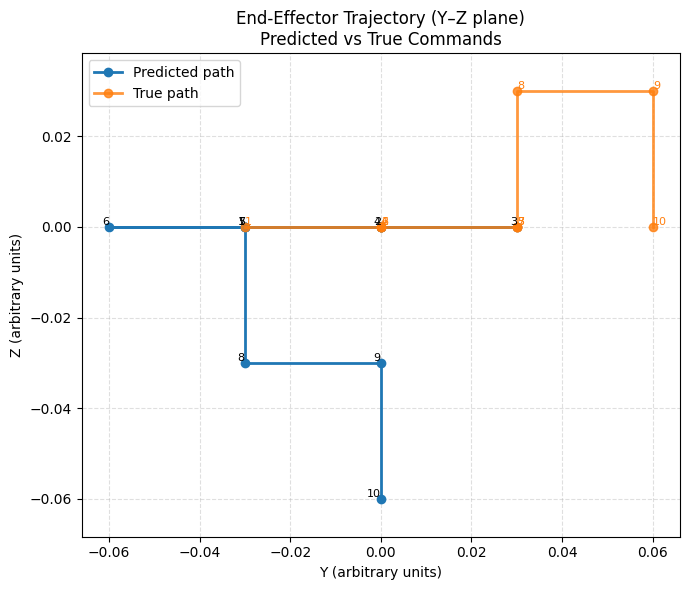

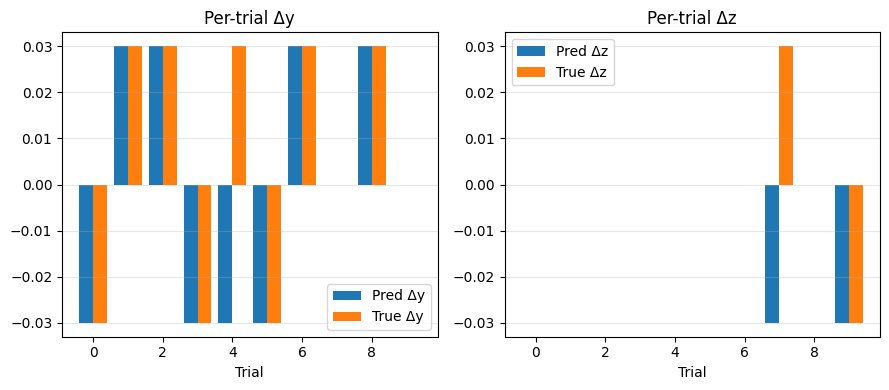

In [1]:
import os
import numpy as np
import pandas as pd
import random
import datetime
import time
import matplotlib.pyplot as plt  # ### NEW: VIS

from pandas import ExcelWriter
from torchsummary import summary
import torch
import math
import warnings
warnings.filterwarnings("ignore")

from torch import nn
from torch import Tensor
from einops.layers.torch import Rearrange, Reduce
from einops import rearrange, reduce, repeat
import torch.nn.functional as F

from utils import calMetrics
from utils import calculatePerClass
from utils import numberClassChannel
from utils import load_data_evaluate

from torch.autograd import Variable

from CTNet_model import EEGTransformer, BranchEEGNetTransformer, PatchEmbeddingCNN, PositioinalEncoding, TransformerEncoder, TransformerEncoderBlock, MultiHeadAttention, FeedForwardBlock, ResidualAdd, ClassificationHead
from interbotix_xs_modules.xs_robot.arm import InterbotixManipulatorXS
from interbotix_common_modules.common_robot.robot import robot_startup, robot_shutdown


# === Settings ===
subject_id = 1  # subject index 1–9
data_dir = './mymat_raw/'
model_path = f'./models/new/model_{subject_id}.pth'  # change if your path differs
dataset_type = 'A'
evaluate_mode = 'subject-dependent'
device = torch.device('cpu')  # Or 'cuda' if using GPU

# === Load and Normalize Test Data ===
_, _, test_data, test_labels = load_data_evaluate(data_dir, dataset_type, subject_id, mode_evaluate=evaluate_mode)
test_data = np.expand_dims(test_data, axis=1)
mean = np.mean(test_data)
std = np.std(test_data) if np.std(test_data) > 0 else 1.0
test_data = (test_data - mean) / std
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# Make labels 1D vector; shift to 0..3 if needed
test_labels = np.asarray(test_labels).reshape(-1)
# Some pipelines store labels in shape (N,1) with values 1..4
if test_labels.min() == 1:
    test_labels = test_labels - 1  # now 0..3

# === Load Model ===
number_class, number_channel = numberClassChannel(dataset_type)
model = EEGTransformer(
    heads=2,
    emb_size=16,
    depth=6,
    database_type=dataset_type,
    eeg1_f1=8,
    eeg1_D=2,
    eeg1_kernel_size=64,
    eeg1_pooling_size1=8,
    eeg1_pooling_size2=8,
    eeg1_dropout_rate=0.5,
    eeg1_number_channel=number_channel,
    flatten_eeg1=240
).to(device)

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict.state_dict() if hasattr(state_dict, "state_dict") else state_dict)
model.eval()

# === Initialize Robot ===
bot = InterbotixManipulatorXS(robot_model='px150', group_name='arm', gripper_name='gripper')
robot_startup()
bot.arm.go_to_home_pose()

# === Movement Step Parameters ===
step_size = 0.03
y = 0.0
z = 0.0

# ### NEW: VIS — paths (cumulative positions) & displacements
pred_y_path = [0.0]
pred_z_path = [0.0]
true_y_path = [0.0]
true_z_path = [0.0]

pred_steps = []
true_steps = []

# === Run Real-Time Simulation Trial-by-Trial ===
trial_times = []
num_trials = min(10, len(test_tensor))
for i in range(num_trials):
    x_input = test_tensor[i].unsqueeze(0).to(device)  # shape: [1, 1, 22, 1000]

    # Start timing
    start_time = time.time()

    # Predict class
    with torch.no_grad():
        # CTNet returns (features, logits); adjust if yours differs
        _, output = model(x_input)
        pred = torch.argmax(output, dim=1).item()

    # Map class -> displacement (predicted)
    dy_pred, dz_pred = 0.0, 0.0
    if pred == 0: dy_pred = -step_size   # left
    elif pred == 1: dy_pred = step_size  # right
    elif pred == 2: dz_pred = step_size  # up
    elif pred == 3: dz_pred = -step_size # down

    # Compute "true" displacement from label
    true_cls = int(test_labels[i])
    dy_true, dz_true = 0.0, 0.0
    if true_cls == 0: dy_true = -step_size
    elif true_cls == 1: dy_true = step_size
    elif true_cls == 2: dz_true = step_size
    elif true_cls == 3: dz_true = -step_size

    # Accumulate predicted path (this is what you actually send to the robot)
    y += dy_pred
    z += dz_pred
    pred_y_path.append(y)
    pred_z_path.append(z)

    # Accumulate the hypothetical true path (what it would be if you followed ground truth)
    true_y_path.append(true_y_path[-1] + dy_true)
    true_z_path.append(true_z_path[-1] + dz_true)

    # Stash step vectors for optional quiver/arrows
    pred_steps.append((dy_pred, dz_pred))
    true_steps.append((dy_true, dz_true))

    # Send command to robot (predicted motion)
    bot.arm.set_ee_cartesian_trajectory(z=dz_pred)
    # belt joint change: scaled by 10π/2 (~rad) — keep as you had
    bot.arm.set_single_joint_position(joint_name='waist', position=y * 10 * np.pi / 2.0)

    # End timing
    end_time = time.time()
    elapsed = end_time - start_time
    trial_times.append(elapsed)
    print(f"[Trial {i+1}] Pred Class: {pred} | True: {true_cls} | "
          f"Δy/Δz pred=({dy_pred:.2f},{dz_pred:.2f}) true=({dy_true:.2f},{dz_true:.2f}) | "
          f"y={y:.2f}, z={z:.2f} | Time: {elapsed:.3f}s")

    time.sleep(2)

# === Wrap Up Robot ===
bot.arm.go_to_sleep_pose()
robot_shutdown()

# === Performance Summary ===
print("\n--- Runtime per Trial ---")
for i, t in enumerate(trial_times):
    print(f"Trial {i+1}: {t:.3f} seconds")
print(f"\nAverage time per trial: {np.mean(trial_times):.3f} seconds")

# === NEW: VISUALIZATION ===
# 1) Y–Z trajectory: predicted vs true
plt.figure(figsize=(7,6))
plt.plot(pred_y_path, pred_z_path, '-o', label='Predicted path', linewidth=2)
plt.plot(true_y_path, true_z_path, '-o', label='True path', linewidth=2, alpha=0.8)

# Annotate each step number
for k in range(1, len(pred_y_path)):
    plt.text(pred_y_path[k], pred_z_path[k], str(k), fontsize=8, va='bottom', ha='right')
    plt.text(true_y_path[k], true_z_path[k], str(k), fontsize=8, va='bottom', ha='left', color='tab:orange')

plt.title('End-Effector Trajectory (Y–Z plane)\nPredicted vs True Commands')
plt.xlabel('Y (arbitrary units)')
plt.ylabel('Z (arbitrary units)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Optional: per-trial displacement bars
plt.figure(figsize=(9,4))
pred_dy = [s[0] for s in pred_steps]
pred_dz = [s[1] for s in pred_steps]
true_dy = [s[0] for s in true_steps]
true_dz = [s[1] for s in true_steps]
idx = np.arange(num_trials)

plt.subplot(1,2,1)
plt.bar(idx-0.2, pred_dy, width=0.4, label='Pred Δy')
plt.bar(idx+0.2, true_dy, width=0.4, label='True Δy')
plt.title('Per-trial Δy')
plt.xlabel('Trial')
plt.grid(True, axis='y', alpha=0.3)
plt.legend()

plt.subplot(1,2,2)
plt.bar(idx-0.2, pred_dz, width=0.4, label='Pred Δz')
plt.bar(idx+0.2, true_dz, width=0.4, label='True Δz')
plt.title('Per-trial Δz')
plt.xlabel('Trial')
plt.grid(True, axis='y', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


/home/mscrobotics2425laptop18/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/mscrobotics2425laptop18/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[INFO] [1755069744.553482737] [interbotix_robot_manipulation]: Initialized InterbotixRobotNode!
[INFO] [1755069744.602465773] [interbotix_robot_manipulation]: 
	Robot Name: px150
	Robot Model: px150
[INFO] [1755069744.602829462] [interbotix_robot_manipulation]: Initialized InterbotixRobotXSCore!
[INFO] [1755069744.606725557] [interboti

[Trial 1] Pred Class: 0 | True: 0 | Δy/Δz pred=(-0.03,0.00) true=(-0.03,0.00) | y=-0.03, z=0.00 | Time: 4.456s
[Trial 2] Pred Class: 1 | True: 1 | Δy/Δz pred=(0.03,0.00) true=(0.03,0.00) | y=0.00, z=0.00 | Time: 4.440s
[Trial 3] Pred Class: 1 | True: 1 | Δy/Δz pred=(0.03,0.00) true=(0.03,0.00) | y=0.03, z=0.00 | Time: 4.436s
[Trial 4] Pred Class: 0 | True: 0 | Δy/Δz pred=(-0.03,0.00) true=(-0.03,0.00) | y=0.00, z=0.00 | Time: 4.432s
[Trial 5] Pred Class: 0 | True: 1 | Δy/Δz pred=(-0.03,0.00) true=(0.03,0.00) | y=-0.03, z=0.00 | Time: 4.435s
[Trial 6] Pred Class: 0 | True: 0 | Δy/Δz pred=(-0.03,0.00) true=(-0.03,0.00) | y=-0.06, z=0.00 | Time: 4.453s
[Trial 7] Pred Class: 1 | True: 1 | Δy/Δz pred=(0.03,0.00) true=(0.03,0.00) | y=-0.03, z=0.00 | Time: 4.464s
[Trial 8] Pred Class: 3 | True: 2 | Δy/Δz pred=(0.00,-0.03) true=(0.00,0.03) | y=-0.03, z=-0.03 | Time: 4.503s
[Trial 9] Pred Class: 1 | True: 1 | Δy/Δz pred=(0.03,0.00) true=(0.03,0.00) | y=0.00, z=-0.03 | Time: 4.454s
[Trial 10] Pr

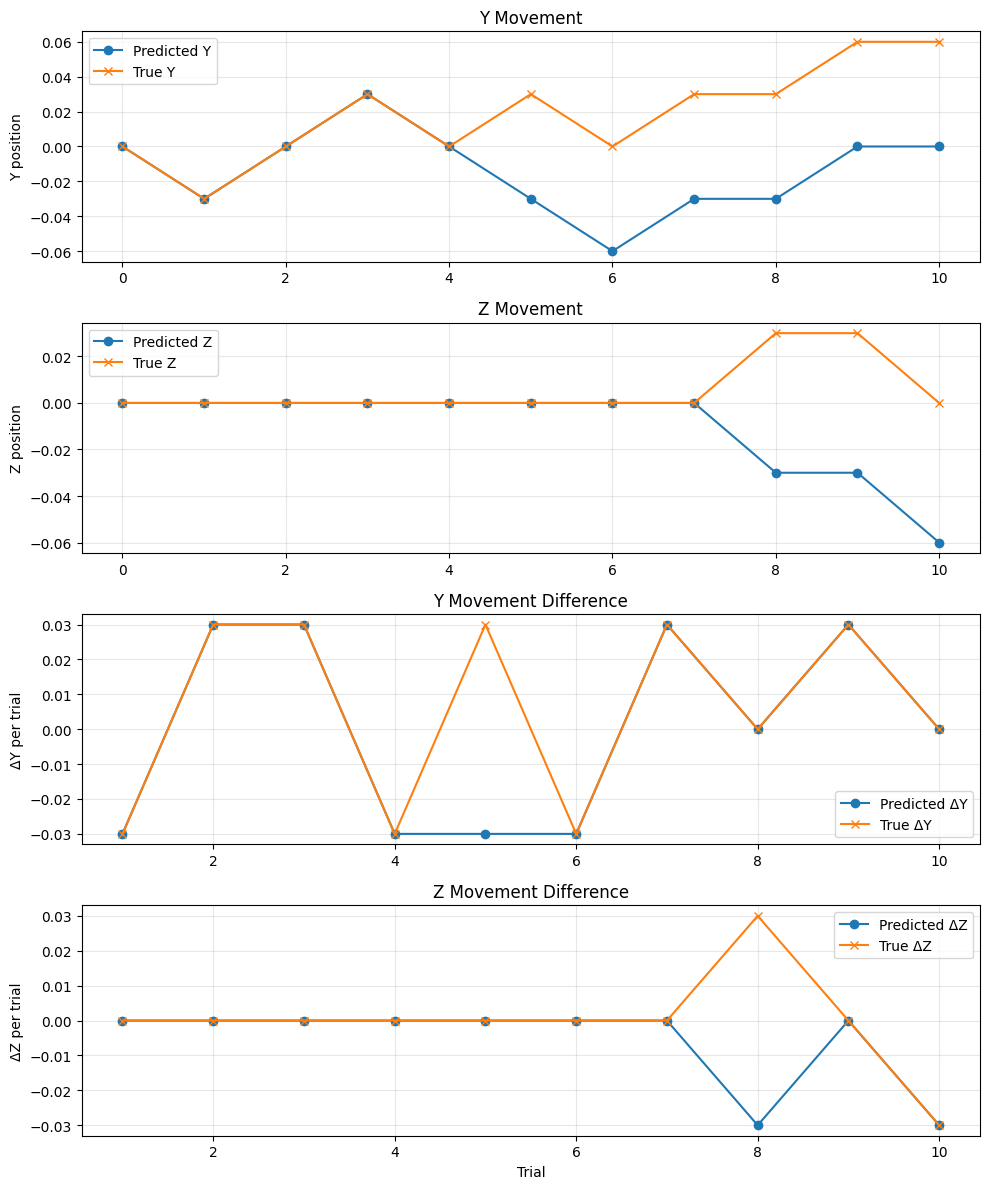

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import datetime
import time
import matplotlib.pyplot as plt  # ### NEW: VIS

from pandas import ExcelWriter
from torchsummary import summary
import torch
import math
import warnings
warnings.filterwarnings("ignore")

from torch import nn
from torch import Tensor
from einops.layers.torch import Rearrange, Reduce
from einops import rearrange, reduce, repeat
import torch.nn.functional as F

from utils import calMetrics
from utils import calculatePerClass
from utils import numberClassChannel
from utils import load_data_evaluate

from torch.autograd import Variable

from CTNet_model import EEGTransformer, BranchEEGNetTransformer, PatchEmbeddingCNN, PositioinalEncoding, TransformerEncoder, TransformerEncoderBlock, MultiHeadAttention, FeedForwardBlock, ResidualAdd, ClassificationHead
from interbotix_xs_modules.xs_robot.arm import InterbotixManipulatorXS
from interbotix_common_modules.common_robot.robot import robot_startup, robot_shutdown


# === Settings ===
subject_id = 1  # subject index 1–9
data_dir = './mymat_raw/'
model_path = f'./models/new/model_{subject_id}.pth'  # change if your path differs
dataset_type = 'A'
evaluate_mode = 'subject-dependent'
device = torch.device('cpu')  # Or 'cuda' if using GPU

# === Load and Normalize Test Data ===
_, _, test_data, test_labels = load_data_evaluate(data_dir, dataset_type, subject_id, mode_evaluate=evaluate_mode)
test_data = np.expand_dims(test_data, axis=1)
mean = np.mean(test_data)
std = np.std(test_data) if np.std(test_data) > 0 else 1.0
test_data = (test_data - mean) / std
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# Make labels 1D vector; shift to 0..3 if needed
test_labels = np.asarray(test_labels).reshape(-1)
# Some pipelines store labels in shape (N,1) with values 1..4
if test_labels.min() == 1:
    test_labels = test_labels - 1  # now 0..3

# === Load Model ===
number_class, number_channel = numberClassChannel(dataset_type)
model = EEGTransformer(
    heads=2,
    emb_size=16,
    depth=6,
    database_type=dataset_type,
    eeg1_f1=8,
    eeg1_D=2,
    eeg1_kernel_size=64,
    eeg1_pooling_size1=8,
    eeg1_pooling_size2=8,
    eeg1_dropout_rate=0.5,
    eeg1_number_channel=number_channel,
    flatten_eeg1=240
).to(device)

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict.state_dict() if hasattr(state_dict, "state_dict") else state_dict)
model.eval()

# === Initialize Robot ===
bot = InterbotixManipulatorXS(robot_model='px150', group_name='arm', gripper_name='gripper')
robot_startup()
bot.arm.go_to_home_pose()

# === Movement Step Parameters ===
step_size = 0.03
y = 0.0
z = 0.0

# ### NEW: VIS — paths (cumulative positions) & displacements
pred_y_path = [0.0]
pred_z_path = [0.0]
true_y_path = [0.0]
true_z_path = [0.0]

pred_steps = []
true_steps = []

# === Run Real-Time Simulation Trial-by-Trial ===
trial_times = []
num_trials = min(10, len(test_tensor))
for i in range(num_trials):
    x_input = test_tensor[i].unsqueeze(0).to(device)  # shape: [1, 1, 22, 1000]

    # Start timing
    start_time = time.time()

    # Predict class
    with torch.no_grad():
        # CTNet returns (features, logits); adjust if yours differs
        _, output = model(x_input)
        pred = torch.argmax(output, dim=1).item()

    # Map class -> displacement (predicted)
    dy_pred, dz_pred = 0.0, 0.0
    if pred == 0: dy_pred = -step_size   # left
    elif pred == 1: dy_pred = step_size  # right
    elif pred == 2: dz_pred = step_size  # up
    elif pred == 3: dz_pred = -step_size # down

    # Compute "true" displacement from label
    true_cls = int(test_labels[i])
    dy_true, dz_true = 0.0, 0.0
    if true_cls == 0: dy_true = -step_size
    elif true_cls == 1: dy_true = step_size
    elif true_cls == 2: dz_true = step_size
    elif true_cls == 3: dz_true = -step_size

    # Accumulate predicted path (this is what you actually send to the robot)
    y += dy_pred
    z += dz_pred
    pred_y_path.append(y)
    pred_z_path.append(z)

    # Accumulate the hypothetical true path (what it would be if you followed ground truth)
    true_y_path.append(true_y_path[-1] + dy_true)
    true_z_path.append(true_z_path[-1] + dz_true)

    # Stash step vectors for optional quiver/arrows
    pred_steps.append((dy_pred, dz_pred))
    true_steps.append((dy_true, dz_true))

    # Send command to robot (predicted motion)
    bot.arm.set_ee_cartesian_trajectory(z=dz_pred)
    # belt joint change: scaled by 10π/2 (~rad) — keep as you had
    bot.arm.set_single_joint_position(joint_name='waist', position=y * 10 * np.pi / 2.0)

    # End timing
    end_time = time.time()
    elapsed = end_time - start_time
    trial_times.append(elapsed)
    print(f"[Trial {i+1}] Pred Class: {pred} | True: {true_cls} | "
          f"Δy/Δz pred=({dy_pred:.2f},{dz_pred:.2f}) true=({dy_true:.2f},{dz_true:.2f}) | "
          f"y={y:.2f}, z={z:.2f} | Time: {elapsed:.3f}s")

    time.sleep(2)

# === Wrap Up Robot ===
bot.arm.go_to_sleep_pose()
robot_shutdown()

# === Performance Summary ===
print("\n--- Runtime per Trial ---")
for i, t in enumerate(trial_times):
    print(f"Trial {i+1}: {t:.3f} seconds")
print(f"\nAverage time per trial: {np.mean(trial_times):.3f} seconds")

# === SIMPLE LINE CHARTS ===
import numpy as np
import matplotlib.pyplot as plt

# Convert paths to arrays
pred_y_arr = np.array(pred_y_path)   # length = num_trials + 1 (starts at 0)
pred_z_arr = np.array(pred_z_path)
true_y_arr = np.array(true_y_path)
true_z_arr = np.array(true_z_path)

# Per-trial deltas (length = num_trials)
pred_dy = np.array([dy for dy, _ in pred_steps])
pred_dz = np.array([dz for _, dz in pred_steps])
true_dy = np.array([dy for dy, _ in true_steps])
true_dz = np.array([dz for _, dz in true_steps])

# X axes
pos_x = np.arange(len(pred_y_arr))          # 0..num_trials (positions)
diff_x = np.arange(1, len(pred_y_arr))      # 1..num_trials (per-trial deltas)

fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=False)

# 1) Y Movement (positions)
axs[0].plot(pos_x, pred_y_arr, label='Predicted Y', marker='o')
axs[0].plot(pos_x, true_y_arr, label='True Y', marker='x')
axs[0].set_title('Y Movement')
axs[0].set_ylabel('Y position')
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# 2) Z Movement (positions)
axs[1].plot(pos_x, pred_z_arr, label='Predicted Z', marker='o')
axs[1].plot(pos_x, true_z_arr, label='True Z', marker='x')
axs[1].set_title('Z Movement')
axs[1].set_ylabel('Z position')
axs[1].grid(True, alpha=0.3)
axs[1].legend()

# 3) Y Movement Difference (per-trial ΔY)
axs[2].plot(diff_x, pred_dy, label='Predicted ΔY', marker='o')
axs[2].plot(diff_x, true_dy, label='True ΔY', marker='x')
axs[2].set_title('Y Movement Difference')
axs[2].set_ylabel('ΔY per trial')
axs[2].grid(True, alpha=0.3)
axs[2].legend()

# 4) Z Movement Difference (per-trial ΔZ)
axs[3].plot(diff_x, pred_dz, label='Predicted ΔZ', marker='o')
axs[3].plot(diff_x, true_dz, label='True ΔZ', marker='x')
axs[3].set_title('Z Movement Difference')
axs[3].set_xlabel('Trial')
axs[3].set_ylabel('ΔZ per trial')
axs[3].grid(True, alpha=0.3)
axs[3].legend()

plt.tight_layout()
# plt.savefig('movement_compare_lines.png', dpi=150)
plt.show()
